In [29]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [30]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import *
from pyspark.sql.types import *

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'dataset_with_electro.csv'
df = spark.read.option("header", "true").csv(filename_data, mode="DROPMALFORMED")
df = df.withColumn("year",df.year.cast(IntegerType())) \
    .withColumn("mileage",df.mileage.cast(IntegerType())) \
    .withColumn("engine_volume",df.engine_volume.cast(DoubleType())) \
    .withColumn("engine_power",df.engine_power.cast(DoubleType())) \
    .withColumn("price",df.price.cast(IntegerType())) \
    .drop("date_posted", "color", "drive", "owners_count", "body_type", "generation", "views_total", "views_today", "engine_volume", "exchange", "vin", "license_plate", "photos_links", "photos_count", "descr", "complectation", "url", "catalog_link", "orig_url", "state", "pts", "customs")

print('Data overview')
df.printSchema()

total_cars_count = df.count()
total_cars_count

Data overview
root
 |-- brand: string (nullable = true)
 |-- model: string (nullable = true)
 |-- offer_id: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- engine_power: double (nullable = true)
 |-- transmission: string (nullable = true)
 |-- wheel: string (nullable = true)
 |-- price: integer (nullable = true)



352844

Пропущенные значения

In [31]:
string_columns = ['brand', 'model', 'offer_id', 'wheel', 'fuel_type', 'transmission']
numeric_columns = ['year','mileage', 'engine_power', 'price']

def view_missing_values_in_columns(string_columns, numeric_columns):
    missing_values = {}
    for index, column in enumerate(df.columns):
        if column in string_columns:
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        else: 
            missing_count = df.where(col(column).isin([0,None,np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    
    return missing_values

pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

brand  model  offer_id   year  mileage  fuel_type  engine_power  \
0  20084   3347     18524  20141    20150      19945         20190   

   transmission  wheel  price  
0         20060  20089  39188

Устраняем пропущенные значения

In [32]:
df = df.dropna(subset=['model'])
df = df.dropna(subset=['brand'])
df = df.dropna(subset=['offer_id'])



df = df.withColumn('price', 
                   when(col('price').isin([0,None,np.nan]) | col('price').isNull(),
                        None).otherwise(col('price')))

df = df.dropna(subset=['price'])

df = df.dropna(subset=['year'])

df = df.dropna(subset=['year'])

df = df.dropna(subset=['engine_power'])

avg_value = df.select(mean('mileage')).collect()[0]['avg(mileage)']

df = df.withColumn('mileage', 
                    when((col('mileage').isin([0,None,np.nan])) | (col('mileage').isNull()),
                        avg_value).otherwise(col('mileage')))

df = df.dropna(subset=['transmission'])



columns = ['fuel_type', 'transmission', 'wheel']
for column in columns:
    distinct_column_values = df.select(column, df.offer_id) \
        .groupBy(column) \
        .count() \
        .orderBy("count", ascending=False) \
        .collect()[:1]
    most_frequency_value = distinct_column_values[0][column]
    df = df.fillna(value=most_frequency_value, subset=[column])

После устранения пустых значений

In [33]:
pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

brand  model  offer_id  year  mileage  fuel_type  engine_power  \
0      0      0         0     0        0          0             0   

   transmission  wheel  price  
0             0      0      0

In [34]:
'Data frame describe (numeric columns only):'
df.select(df.year, df.mileage, df.engine_power, df.price).describe().toPandas()

'Data frame describe (numeric columns only):'

summary                year             mileage        engine_power  \
0   count              313650              313650              313650   
1    mean  2007.9156767097084  152803.13161166906  135.96934162282798   
2  stddev   8.602561321132837   97233.28912859742   70.39334264702842   
3     min                1927                 1.0                 7.0   
4     max                2021           1000000.0              1000.0   

                price  
0              313650  
1   695426.9184760083  
2  1012924.0266198245  
3                   1  
4            78286680

Чтобы избавиться от выбросов, используем межквартильный диапазон

In [35]:
for column in ['mileage', 'engine_power', 'price']:

    # Q1 : First Quartile ., Q3 : Third Quartile
    Q1 = df.approxQuantile(column,[0.25],relativeError=0)
    Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
    # IQR : Inter Quantile Range
    # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
    # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
    IQR = Q3[0] - Q1[0]
        
    #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
    less_Q1 =  Q1[0] - 1.5*IQR
    more_Q3 =  Q3[0] + 1.5*IQR
           
    df = df.filter((df[column] < more_Q3) & (df[column] > less_Q1))    

df.select(df.year, df.mileage, df.engine_power, df.price).describe().toPandas()

summary                year             mileage        engine_power  \
0   count              259399              259399              259399   
1    mean  2007.3504061310953  150942.98205467252   115.1877339542558   
2  stddev   8.422876274501327   81463.29699438346  37.978215280052424   
3     min                1932                 1.0                 7.0   
4     max                2021            373500.0               242.0   

               price  
0             259399  
1  435436.4143308186  
2  326543.7814905362  
3                  1  
4            1466000

Вывод 10 популярных бредов автомобилей

Top 10 cars brands:


/tmp/ipykernel_61/3776497711.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  xsticks_label = axs[0].set_xticklabels(highest_cars_brands_df['brand'],


brand   count  percentage
0  LADA (ВАЗ)   61376   17.394656
1     Hyundai   15179    4.301901
2      Nissan   14717    4.170965
3      Toyota   14673    4.158495
4         Kia   13753    3.897757
5  Volkswagen   12392    3.512034
6   Chevrolet   11691    3.313362
7        Ford   10956    3.105055
8     Renault    9739    2.760143
9        Opel    8741    2.477299
0      others  179627   50.908333

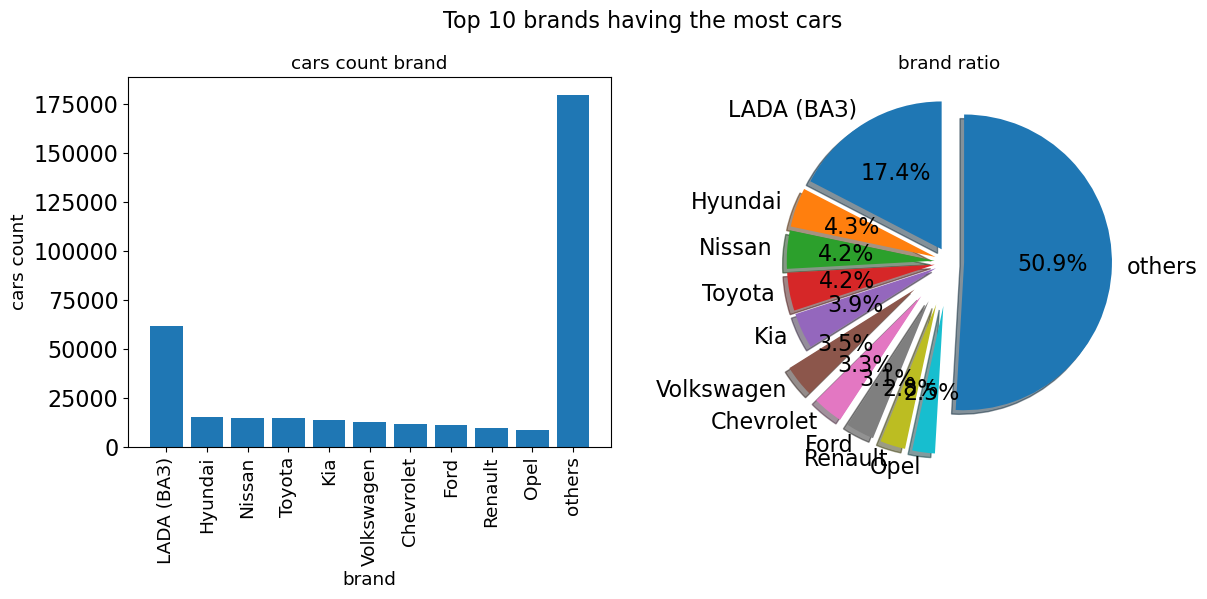

In [37]:
highest_cars_brands_df = df.select(df.brand, df.offer_id) \
    .groupBy(df.brand) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10) \
    .toPandas()


highest_cars_brands_df['percentage'] = highest_cars_brands_df['count'] \
    / total_cars_count * 100

others = {
    'brand': 'others', 
    'count': total_cars_count - np.sum(highest_cars_brands_df['count']), 
    'percentage': 100 - np.sum(highest_cars_brands_df['percentage'])
}

highest_cars_brands_df = pd.concat([highest_cars_brands_df,pd.DataFrame.from_dict([others])])


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_cars_brands_df['brand'], 
                     height=highest_cars_brands_df['count'])
title0 =  axs[0].set_title('cars count brand', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('brand', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('cars count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_cars_brands_df['brand'],
                                       rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.3,0.3,0.3,0.3,0.3,0.1)
title1 = axs[1].set_title('brand ratio', fontsize = 'small')
plot1 = axs[1].pie(
    x=highest_cars_brands_df['percentage'],
    labels=highest_cars_brands_df['brand'], 
    autopct='%1.1f%%', 
    shadow=True, 
    explode=explode, 
    startangle=90, 
    radius=1
)

print('Top 10 cars brands:')
highest_cars_brands_df


text = fig.text(0.5, 1.02, 'Top 10 brands having the most cars', ha='center', va='top', transform=fig.transFigure)

Диграмма распределения брендов в расположении рулевого колеса

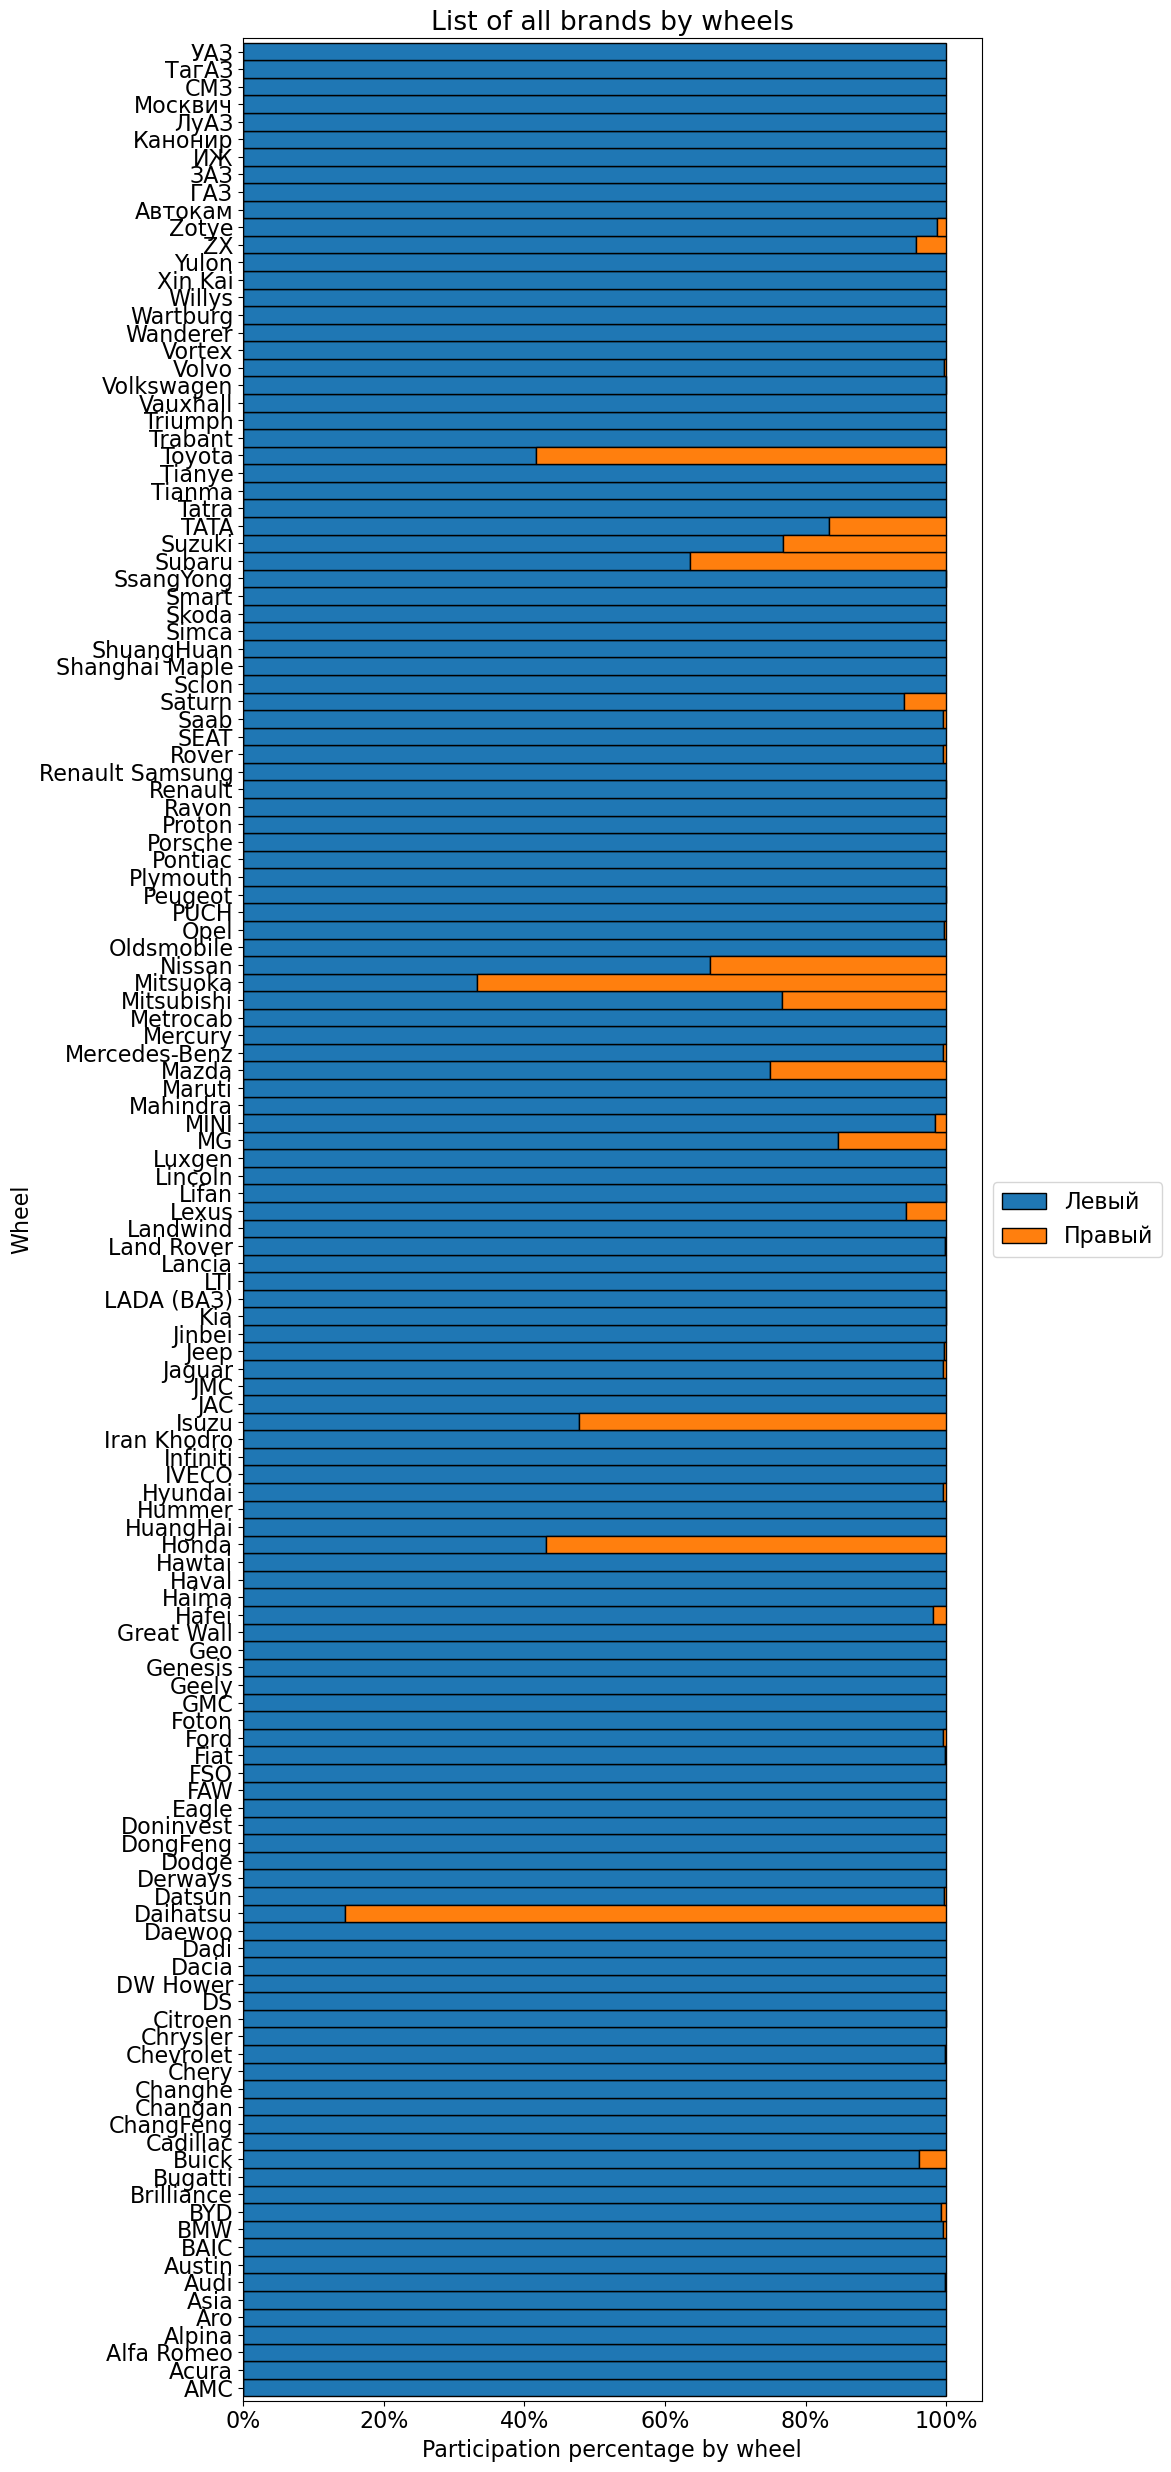

In [38]:
brands_by_wheel_df = df.groupBy(df.brand, df.wheel).count().toPandas()

wheels = brands_by_wheel_df['wheel'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = brands_by_wheel_df.groupby(['brand', 'wheel'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='List of all brands by wheels')
ylabel = plt.ylabel('Wheel');
xlabel = plt.xlabel('Participation percentage by wheel');
legend = plt.legend(
    sorted(wheels), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

Находим 10 популярных брендов с левым и правым расположением руля

In [39]:
brands_by_wheel_df = df.groupBy(df.brand, df.wheel).count().toPandas().pivot_table(
    index="brand", columns="wheel", values='count', fill_value=0) \
    .reset_index() \
    .rename_axis(None, axis=1) \
    
brands_by_wheel_df['всего'] = 0
for wheel in wheels:
    brands_by_wheel_df['всего'] += brands_by_wheel_df[wheel]
    
brands_by_wheel_df['процент'] = brands_by_wheel_df['всего'] / np.sum(brands_by_wheel_df['всего']) * 100

for wheel in wheels:
    brands_by_wheel_df['процент ' + wheel + ' руль'] = \
        (brands_by_wheel_df[wheel] / brands_by_wheel_df['всего']) * 100

top_brands_by_wheel_df = brands_by_wheel_df.sort_values(
    by='процент', ascending=False
).head(10)

others = {'brand' : 'others'}
for column in [*['всего', 'процент'], *wheels,]:
    value = np.sum(brands_by_wheel_df[column]) - np.sum(top_brands_by_wheel_df[column])
    others.update({column: value})

for wheel in wheels:
    value = (others[wheel] / others['всего']) * 100
    others.update({'процент ' + wheel  + ' руль': value})
    
top_brands_by_wheel_df = pd.concat([top_brands_by_wheel_df,pd.DataFrame.from_dict([others])]) \
                                .reset_index(drop=True)

top_brands_by_wheel_df

brand  Левый  Правый  всего    процент  процент Левый руль  \
0   LADA (ВАЗ)  61374       2  61376  23.660847           99.996741   
1      Hyundai  15105      74  15179   5.851603           99.512484   
2       Nissan   9765    4952  14717   5.673499           66.351838   
3       Toyota   6116    8557  14673   5.656537           41.682001   
4          Kia  13745       8  13753   5.301871           99.941831   
5   Volkswagen  12381      11  12392   4.777197           99.911233   
6    Chevrolet  11675      16  11691   4.506956           99.863143   
7         Ford  10910      46  10956   4.223609           99.580139   
8      Renault   9736       3   9739   3.754448           99.969196   
9         Opel   8718      23   8741   3.369712           99.736872   
10      others  78253    7929  86182  33.223721           90.799703   

    процент Правый руль  
0              0.003259  
1              0.487516  
2             33.648162  
3             58.317999  
4              0.058169  
5              0.088767  
6              0.136857  
7              0.419861  
8              0.030804  
9              0.263128  
10             9.200297

Найдём 10 брендов, которые используют правый руль

In [40]:
top_brands_by_manual_wheel_df = brands_by_wheel_df.sort_values(
    by='процент Правый руль', ascending=False
).head(10).reset_index(drop=True)

top_brands_by_manual_wheel_df

brand  Левый  Правый  всего   процент  процент Левый руль  \
0    Daihatsu     52     308    360  0.138782           14.444444   
1    Mitsuoka      1       2      3  0.001157           33.333333   
2      Toyota   6116    8557  14673  5.656537           41.682001   
3       Honda   2211    2923   5134  1.979190           43.065836   
4       Isuzu     66      72    138  0.053200           47.826087   
5      Subaru   1101     632   1733  0.668083           63.531448   
6      Nissan   9765    4952  14717  5.673499           66.351838   
7       Mazda   4758    1591   6349  2.447581           74.940936   
8  Mitsubishi   5958    1815   7773  2.996542           76.649942   
9      Suzuki   1545     466   2011  0.775254           76.827449   

   процент Правый руль  
0            85.555556  
1            66.666667  
2            58.317999  
3            56.934164  
4            52.173913  
5            36.468552  
6            33.648162  
7            25.059064  
8            23.350058  
9            23.172551

Находим 10 популярных брендов с разными коробками передач

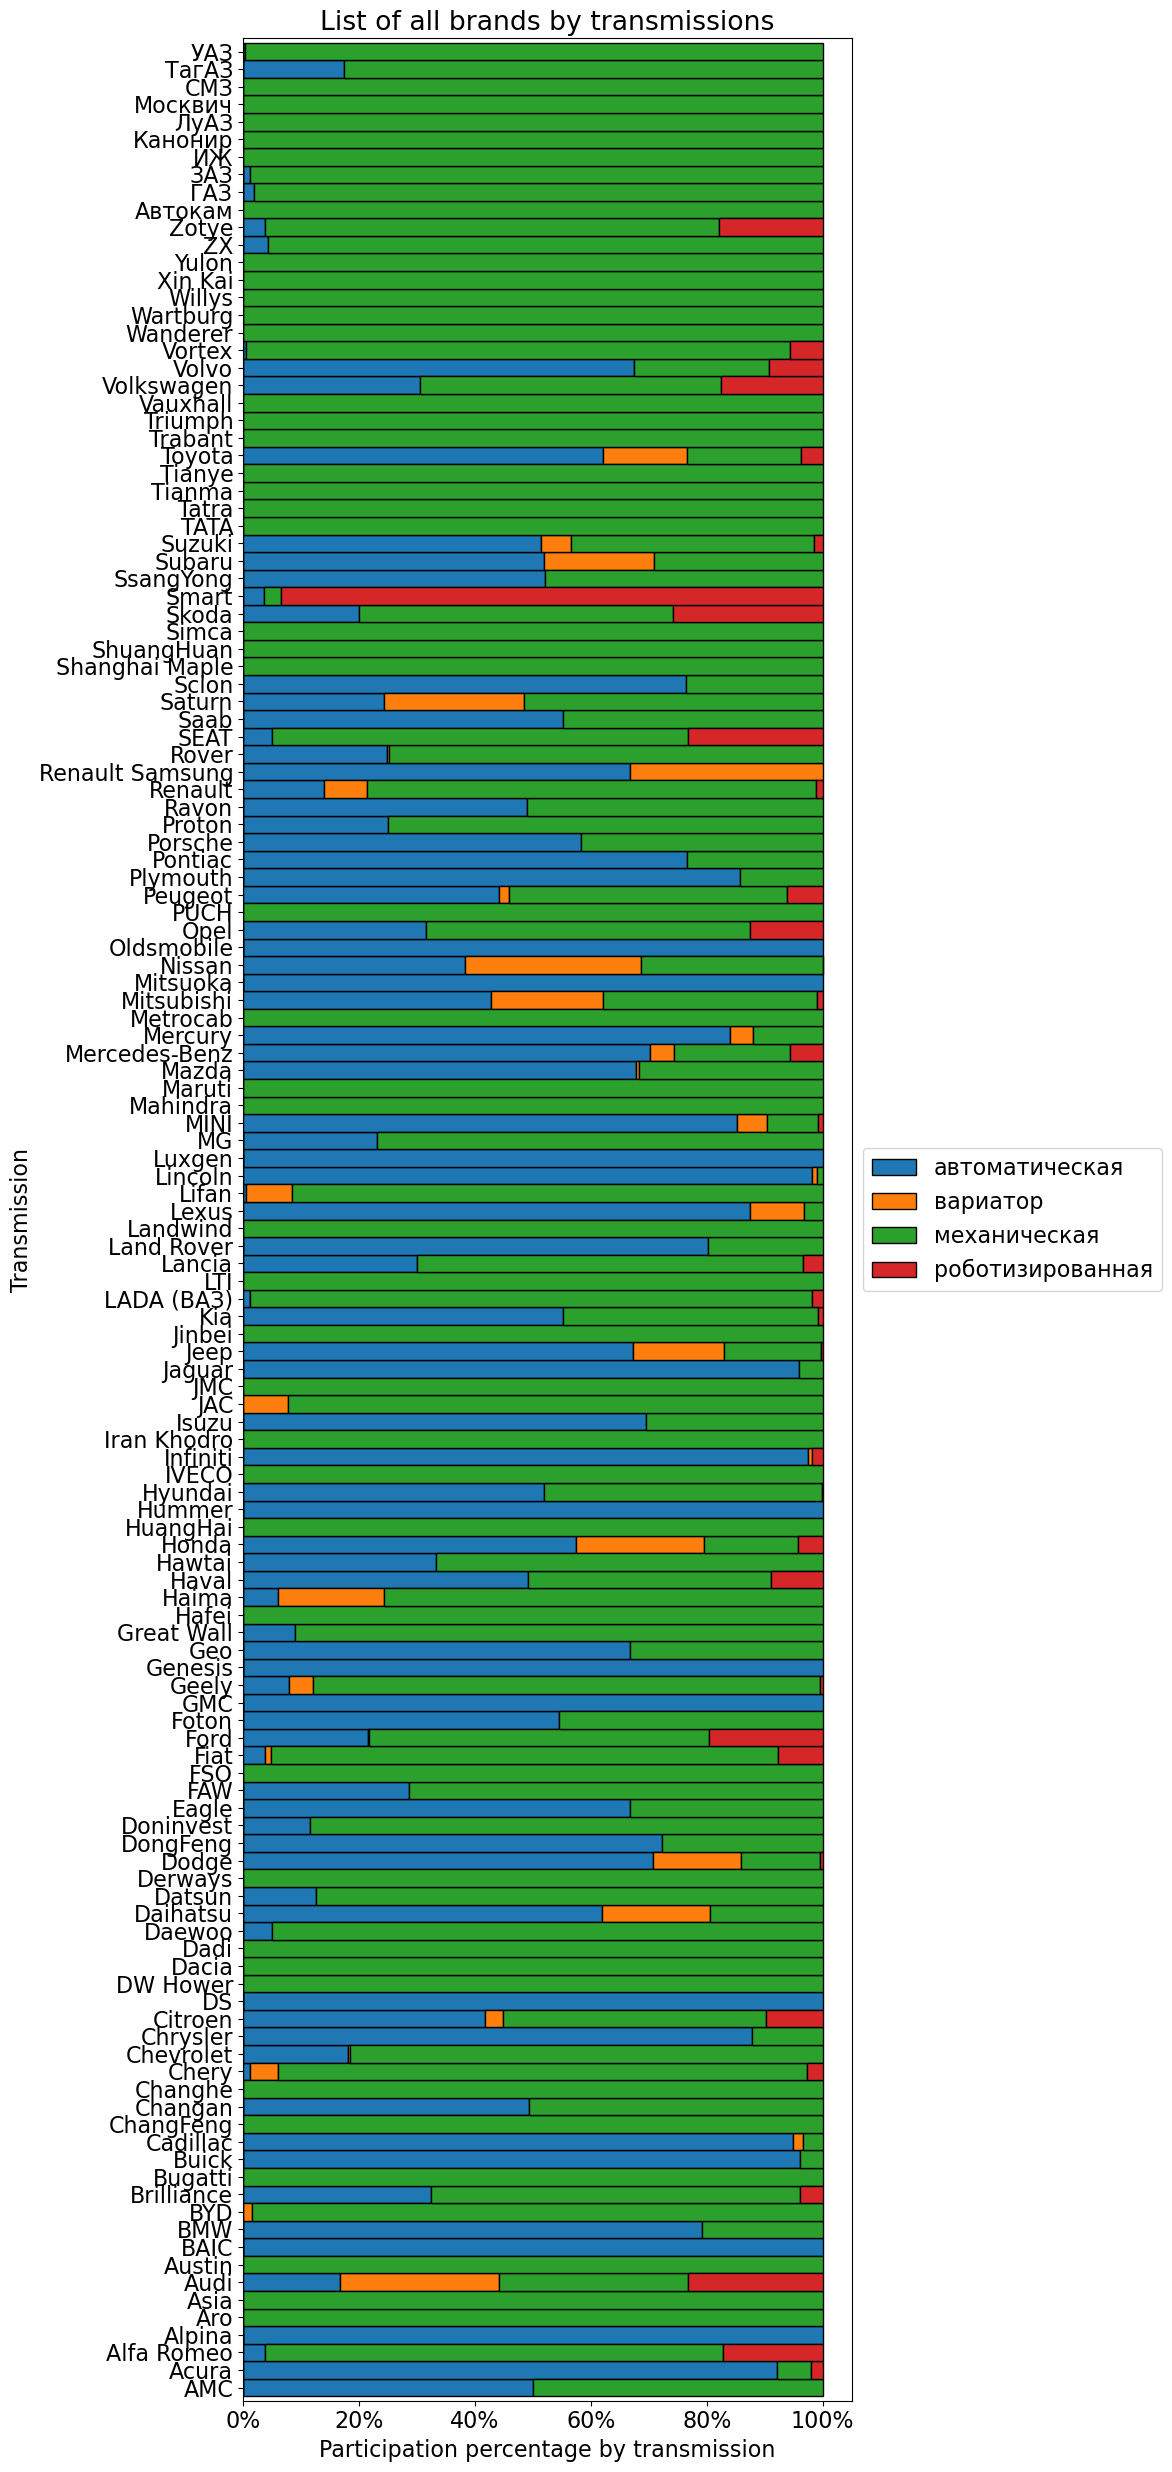

In [41]:
brands_by_transmission_df = df.groupBy(df.brand, df.transmission).count().toPandas()

transmissions = brands_by_transmission_df['transmission'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = brands_by_transmission_df.groupby(['brand', 'transmission'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='List of all brands by transmissions')
ylabel = plt.ylabel('Transmission');
xlabel = plt.xlabel('Participation percentage by transmission');
legend = plt.legend(
    sorted(transmissions), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

Процентное соотношение использование КПП брендами

In [42]:
brands_by_transmission_df = df.groupBy(df.brand, df.transmission).count().toPandas().pivot_table(
    index="brand", columns="transmission", values='count', fill_value=0) \
    .reset_index() \
    .rename_axis(None, axis=1) \
    
brands_by_transmission_df['всего'] = 0
for transmission in transmissions:
    brands_by_transmission_df['всего'] += brands_by_transmission_df[transmission]
    
brands_by_transmission_df['процент'] = brands_by_transmission_df['всего'] / np.sum(brands_by_transmission_df['всего']) * 100

for transmission in transmissions:
    brands_by_transmission_df['процент ' + transmission] = \
        (brands_by_transmission_df[transmission] / brands_by_transmission_df['всего']) * 100

top_brands_by_transmission_df = brands_by_transmission_df.sort_values(
    by='процент', ascending=False
).head(10)

others = {'brand' : 'others'}
for column in [*['всего', 'процент'], *transmissions,]:
    value = np.sum(brands_by_transmission_df[column]) - np.sum(top_brands_by_transmission_df[column])
    others.update({column: value})

for transmission in transmissions:
    value = (others[transmission] / others['всего']) * 100
    others.update({'процент ' + transmission: value})
    
top_brands_by_transmission_df = pd.concat([top_brands_by_transmission_df,pd.DataFrame.from_dict([others])]) \
                                .reset_index(drop=True)

top_brands_by_transmission_df

brand  автоматическая  вариатор  механическая  роботизированная  \
0   LADA (ВАЗ)             692        67         59454              1163   
1      Hyundai            7884         0          7269                26   
2       Nissan            5636      4467          4613                 1   
3       Toyota            9106      2128          2896               543   
4          Kia            7583         0          6051               119   
5   Volkswagen            3783         0          6425              2184   
6    Chevrolet            2121        33          9537                 0   
7         Ford            2366        15          6424              2151   
8      Renault            1356       720          7541               122   
9         Opel            2762         0          4883              1096   
10      others           31522      5443         44827              4390   

    всего    процент  процент автоматическая  процент механическая  \
0   61376  23.660847                1.127477             96.868483   
1   15179   5.851603               51.940181             47.888530   
2   14717   5.673499               38.295848             31.344703   
3   14673   5.656537               62.059565             19.736932   
4   13753   5.301871               55.137061             43.997673   
5   12392   4.777197               30.527760             51.847966   
6   11691   4.506956               18.142161             81.575571   
7   10956   4.223609               21.595473             58.634538   
8    9739   3.754448               13.923401             77.430948   
9    8741   3.369712               31.598215             55.863174   
10  86182  33.223721               36.576083             52.014342   

    процент вариатор  процент роботизированная  
0           0.109163                  1.894877  
1           0.000000                  0.171289  
2          30.352653                  0.006795  
3          14.502828                  3.700675  
4           0.000000                  0.865266  
5           0.000000                 17.624274  
6           0.282268                  0.000000  
7           0.136911                 19.633078  
8           7.392956                  1.252695  
9           0.000000                 12.538611  
10          6.315704                  5.093871

Распределение цен на автомобили

array([[<AxesSubplot: title={'center': 'price'}>]], dtype=object)

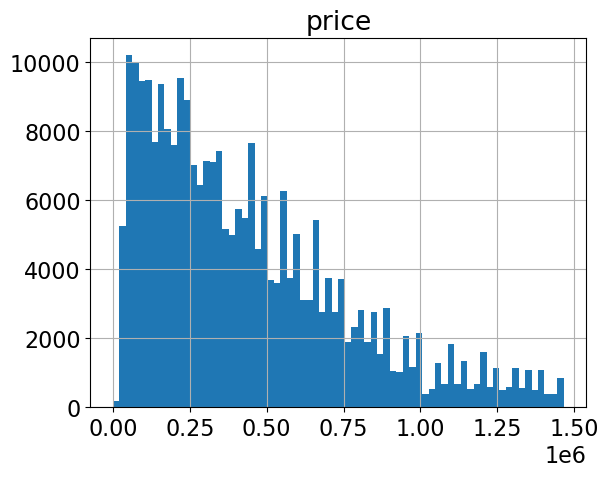

In [43]:
df.select(df.price, df.offer_id).toPandas().hist(column='price',bins=70)

Отобразим, какие среднии цены были на свежие автомобили (5-ти летки)

<AxesSubplot: xlabel='year'>

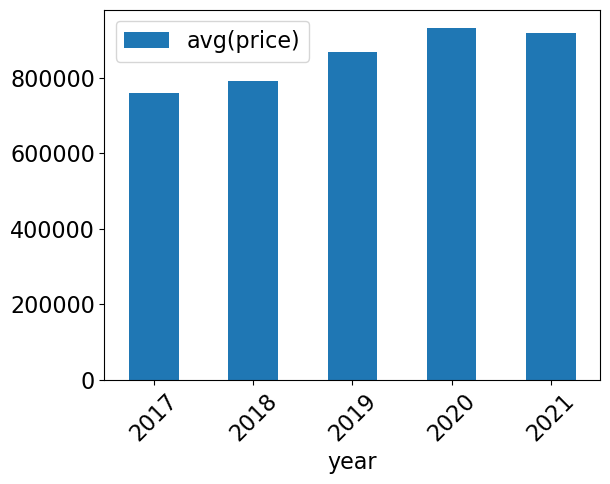

In [44]:
years = [2021,2020,2019,2018,2017]

df.select(df.year, df.price) \
    .filter(df.year.isin(years)) \
    .groupBy(df.year) \
    .avg('price') \
    .toPandas() \
    .sort_values(by='year') \
    .plot.bar(column="avg(price)", x='year', rot=45)

Средняя цена на каждого бренда

<AxesSubplot: ylabel='brand'>

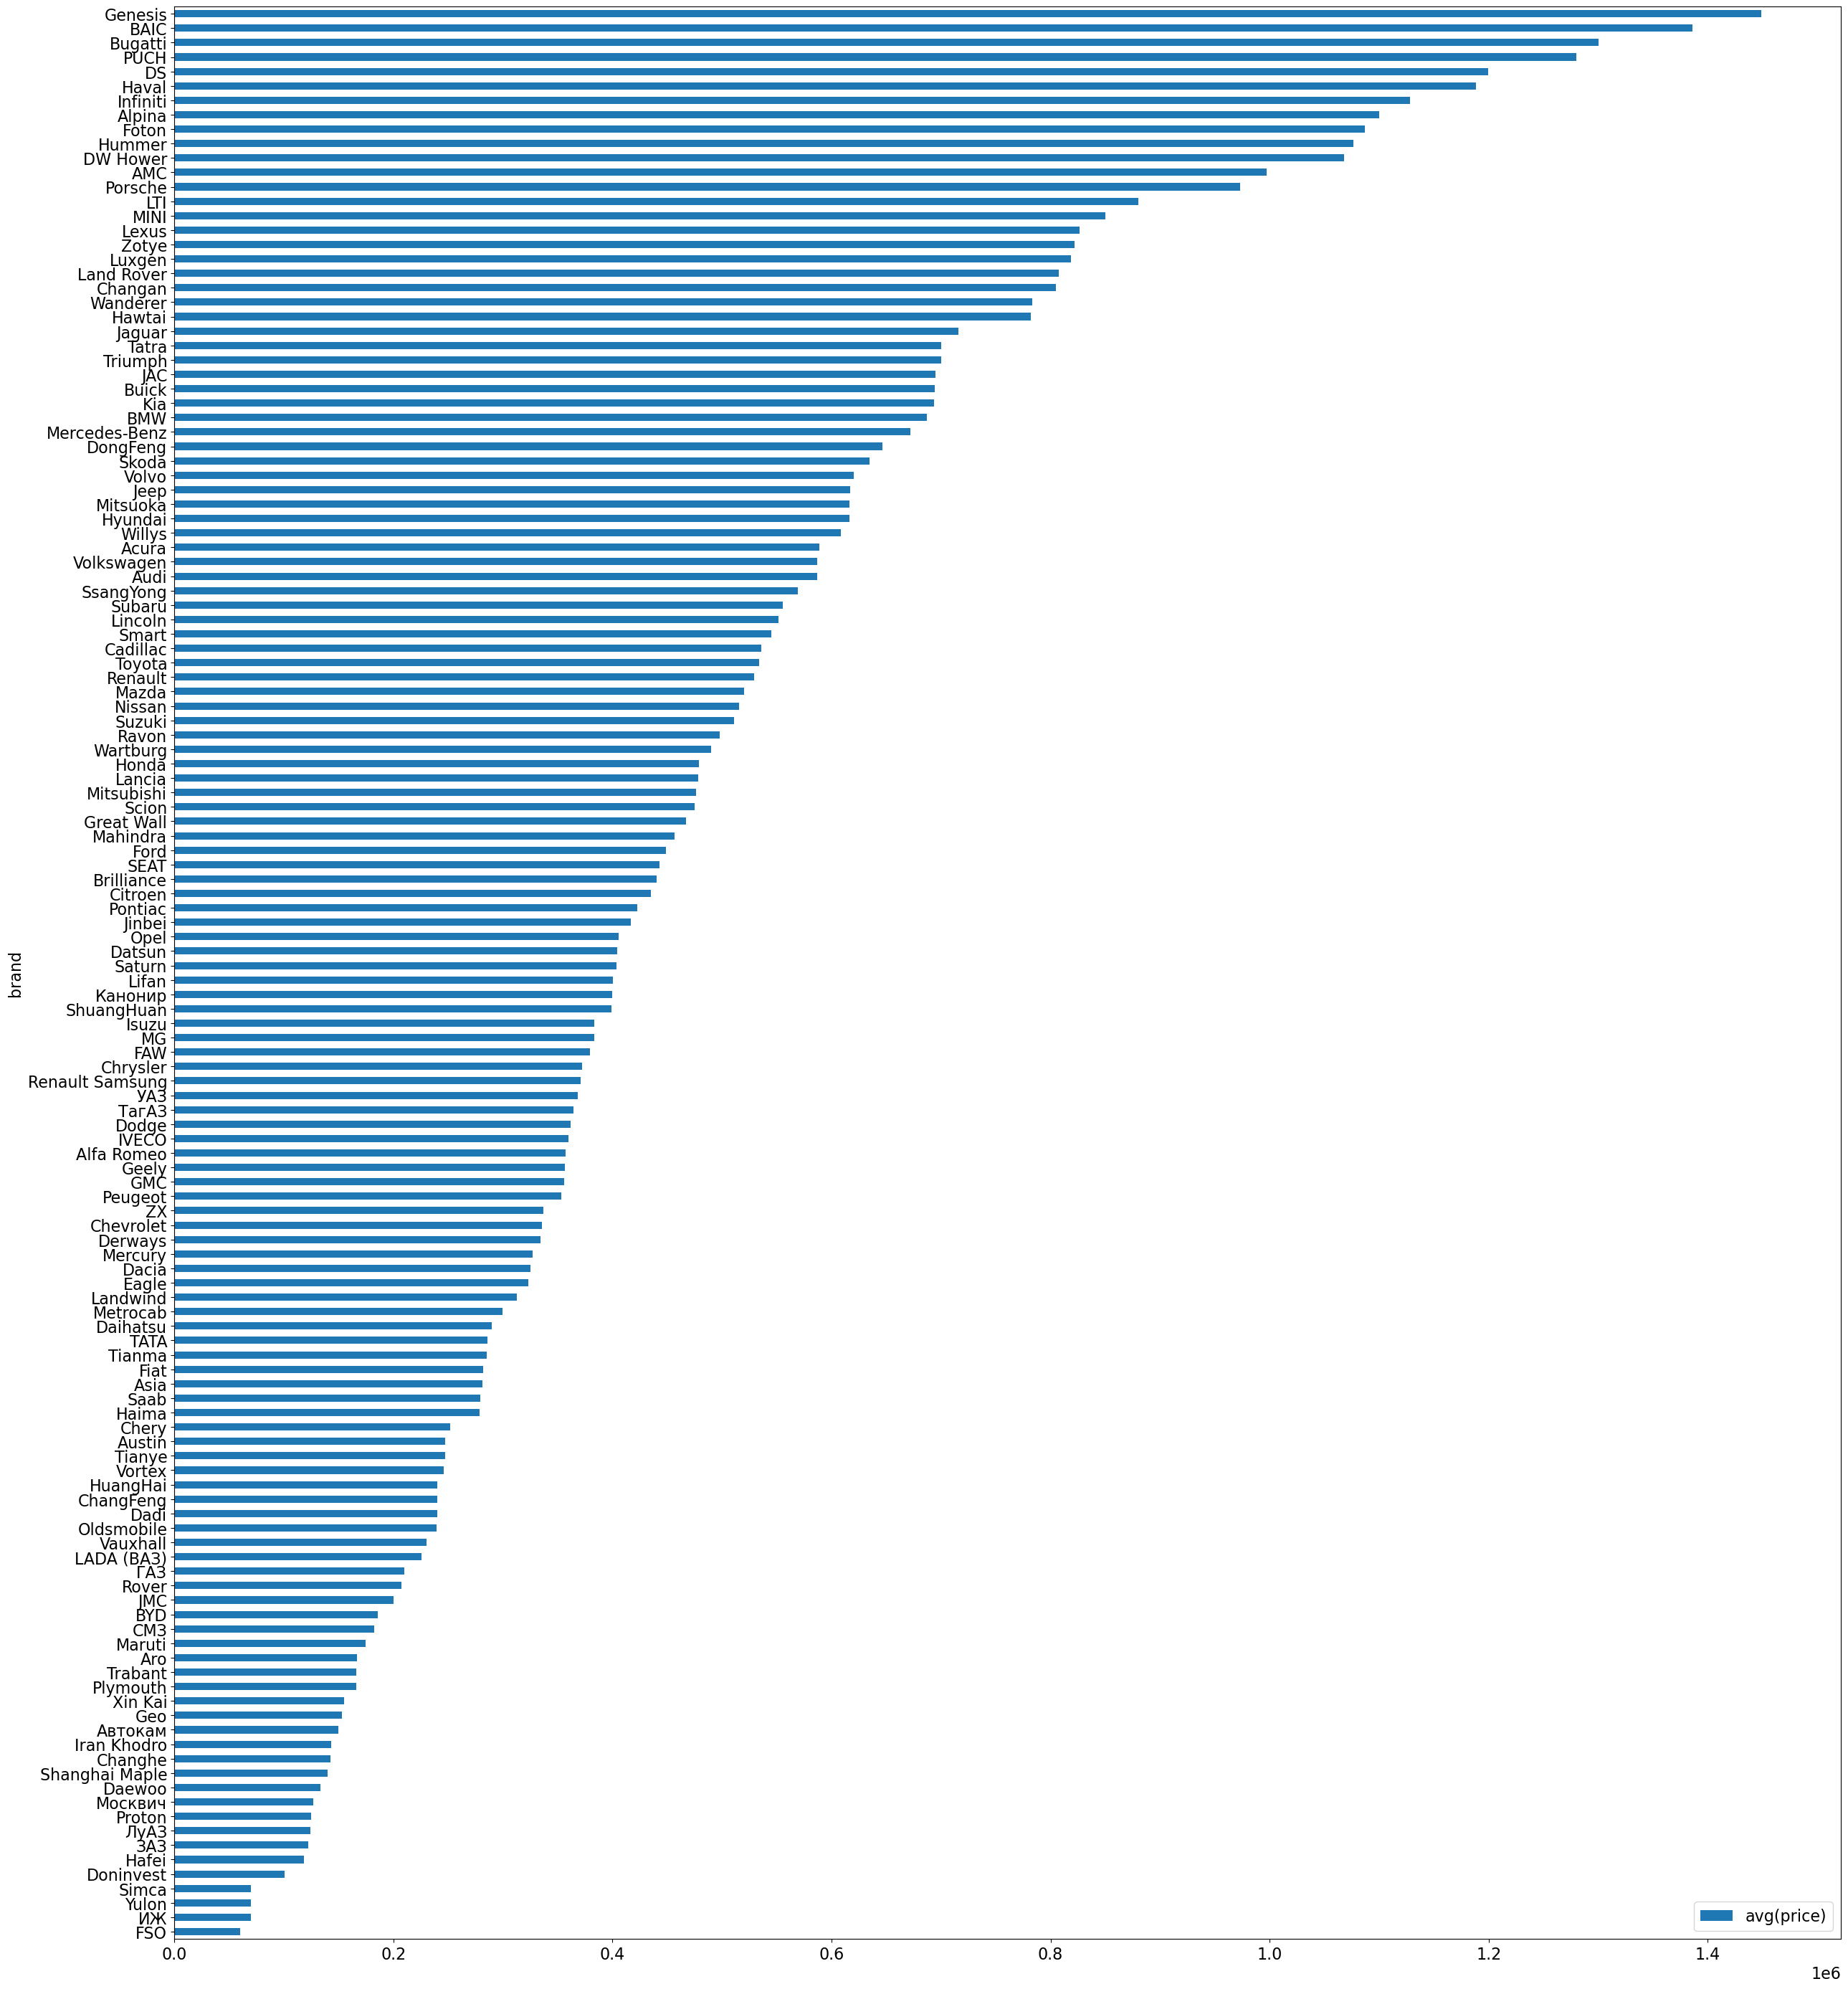

In [45]:
df.select(df.brand, df.price) \
    .groupBy(df.brand) \
    .avg('price') \
    .toPandas() \
    .sort_values(by='avg(price)') \
    .plot.barh(column="avg(price)", x='brand', figsize=(30,35))

Топ 5 продажи автомобилей возрастом от 2021 до 2017

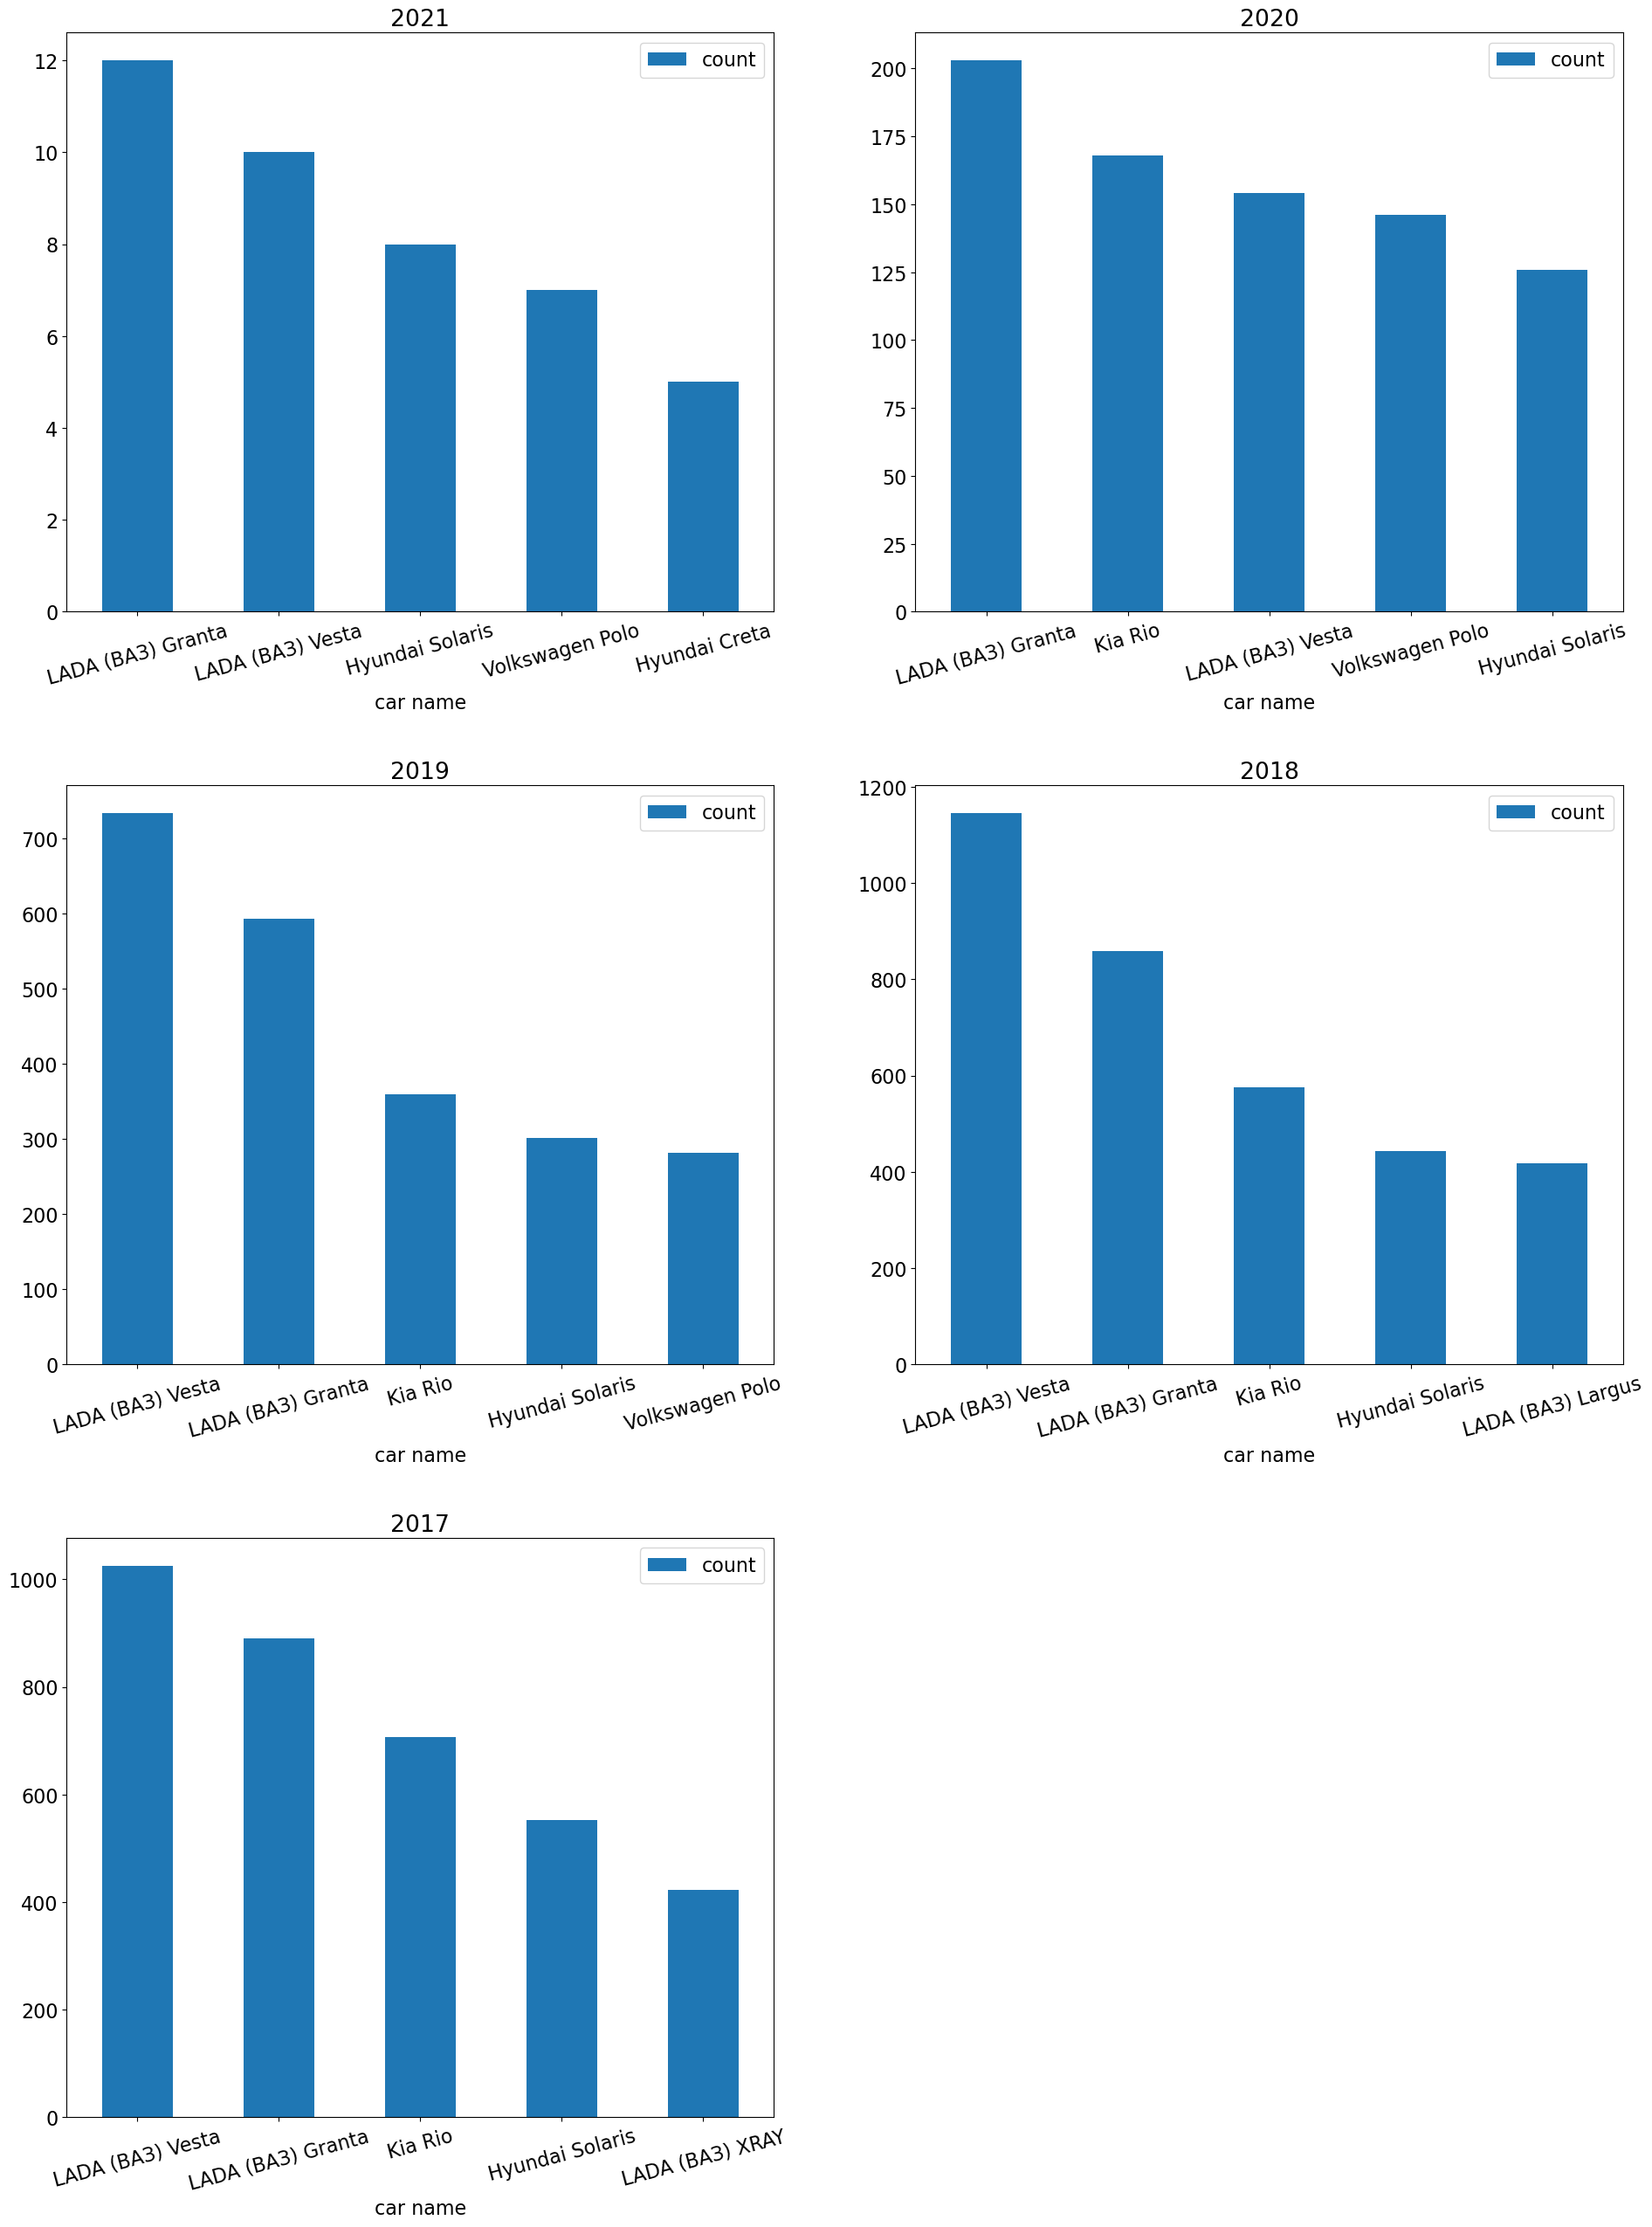

In [46]:
@udf(returnType=StringType()) 
def get_full_car_name_udf(car_brand, car_model):
    return car_brand + ' '+ car_model

plot_size_x, plot_size_y = 10, 10
figsize_x, figsize_y = plot_size_x * 2 + 3, plot_size_y * 3 + 1
figsize=(figsize_x, figsize_y)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(figsize_x, figsize_y))


for i in range(len(years)):
    row_index, col_index = divmod(i, 2)
    top_sold_by_year = df.select(get_full_car_name_udf(df.brand, df.model).alias('car name'), df.year) \
        .filter(df.year == years[i]) \
        .groupBy('car name') \
        .count() \
        .toPandas() \
        .sort_values(by='count', ascending=False) \
        .head(5)
    _ = top_sold_by_year.plot.bar(column="count", x='car name', rot=15, ax = ax[row_index, col_index])
    _ = ax[row_index, col_index].set_title(years[i])

ax[2, 1].set_visible(False)
plt.subplots_adjust(hspace=0.3)

Средняя мощность двигателя у 10 брендов

In [47]:
highest_cars_brands_engine_power_mean = []
highest_cars_brands_engine_power_stddev = []
highest_cars_brands_engine_power_min = []
highest_cars_brands_engine_power_max = []

for brand in highest_cars_brands_df['brand']:
    if brand != 'others': 
        describe_values = df.select(df.engine_power).filter(df.brand == brand).describe().toPandas()
    else:
        brands = highest_cars_brands_df['brand'].tolist()
        describe_values = df.select(df.engine_power).filter(col('brand').isin(brands) == False).describe().toPandas()
    highest_cars_brands_engine_power_mean.append(float(describe_values.loc[1]['engine_power']))
    highest_cars_brands_engine_power_stddev.append(float(describe_values.loc[2]['engine_power']))
    highest_cars_brands_engine_power_min.append(float(describe_values.loc[3]['engine_power']))
    highest_cars_brands_engine_power_max.append(float(describe_values.loc[4]['engine_power']))

highest_cars_brands_df['mean engine power'] = highest_cars_brands_engine_power_mean
highest_cars_brands_df['stddev engine power'] = highest_cars_brands_engine_power_stddev
highest_cars_brands_df['min engine power'] = highest_cars_brands_engine_power_min
highest_cars_brands_df['max engine power'] = highest_cars_brands_engine_power_max
    
highest_cars_brands_df

brand   count  percentage  mean engine power  stddev engine power  \
0  LADA (ВАЗ)   61376   17.394656          85.132641            13.849657   
1     Hyundai   15179    4.301901         126.045260            25.591771   
2      Nissan   14717    4.170965         129.066454            33.891881   
3      Toyota   14673    4.158495         130.155865            37.105308   
4         Kia   13753    3.897757         127.034901            24.835388   
5  Volkswagen   12392    3.512034         124.032682            36.409803   
6   Chevrolet   11691    3.313362          98.850141            26.537330   
7        Ford   10956    3.105055         123.448613            30.839447   
8     Renault    9739    2.760143         102.891262            23.001455   
9        Opel    8741    2.477299         123.566983            32.615123   
0      others  179627   50.908333         128.304658            44.450384   

   min engine power  max engine power  
0              29.0             150.0  
1              56.0             242.0  
2              48.0             240.0  
3               7.0             242.0  
4              60.0             238.0  
5              34.0             241.0  
6              52.0             233.0  
7              50.0             242.0  
8              45.0             241.0  
9              23.0             240.0  
0              10.0             242.0

Диаграмма "с усами" по всем произовителям с мощностью двигателя

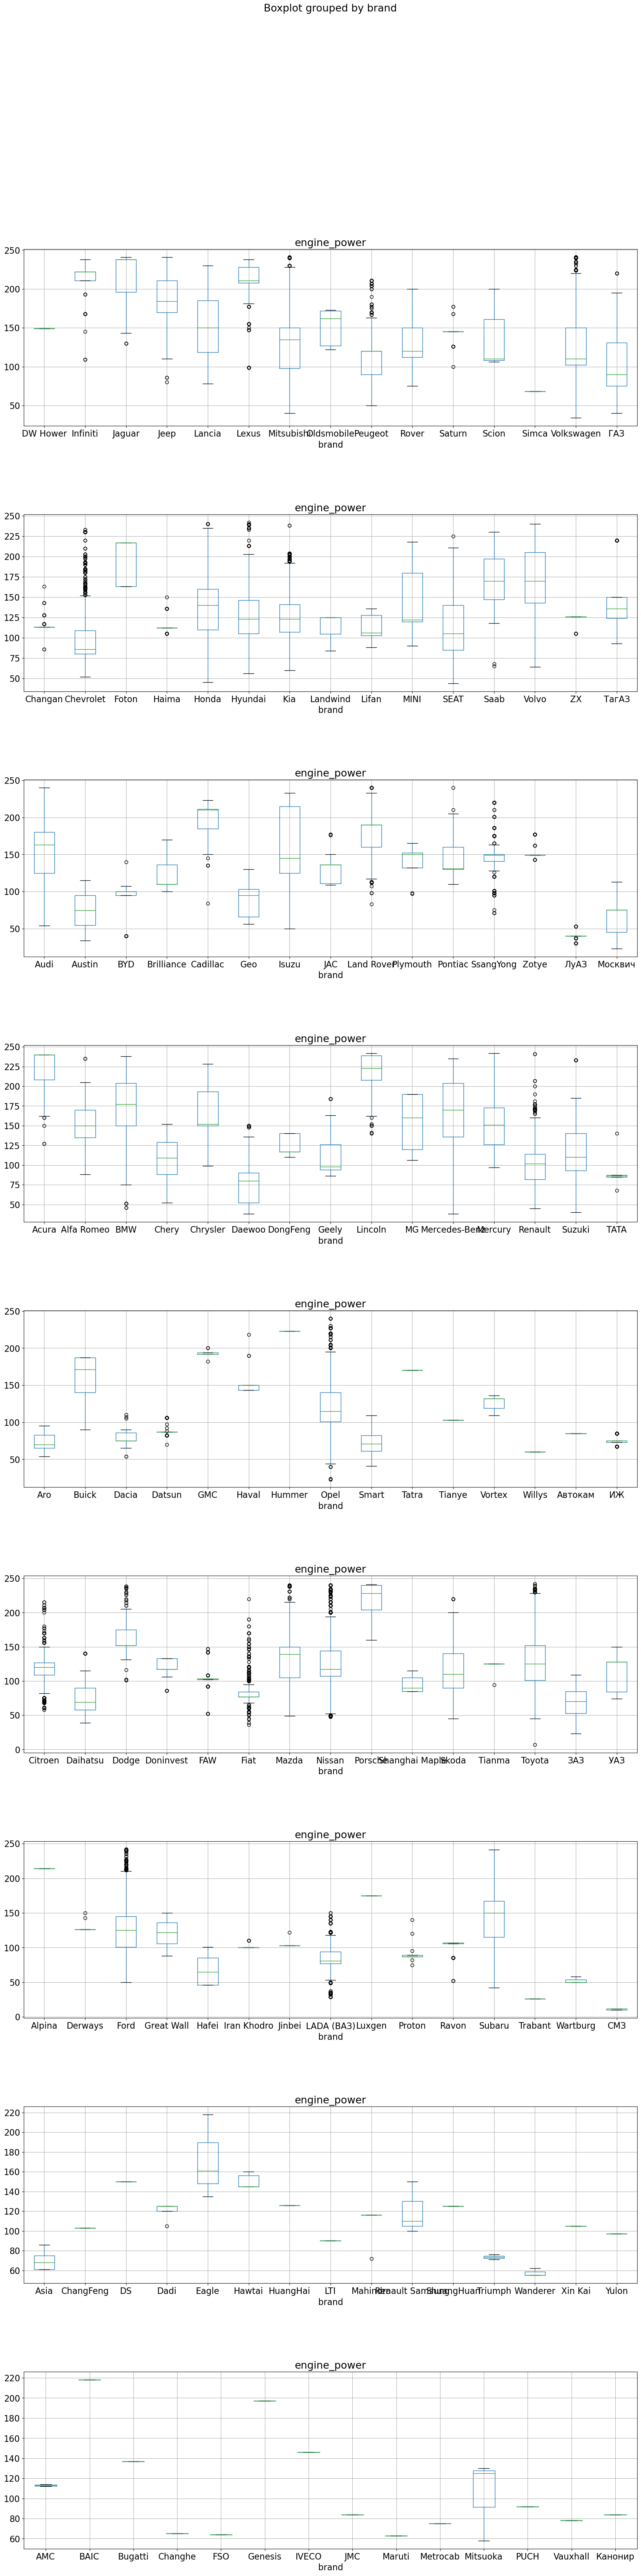

In [48]:
all_brands = df.select(df.brand).distinct().toPandas()
boxplot_cols = 15
boxplot_rows = math.ceil(all_brands.count()/boxplot_cols)

fig, axes = plt.subplots(boxplot_rows, figsize=(20, 80))

for row in range(0,boxplot_rows):
    current_brands = all_brands.iloc[row*boxplot_cols:row*boxplot_cols+boxplot_cols]['brand'].values.tolist()
    engine_power_df = df.select(df.brand, df.engine_power).filter(col('brand').isin(current_brands)).toPandas()
    engine_power_df['engine_power'] = engine_power_df['engine_power'].astype('float')
    engine_power_df.boxplot(column='engine_power', by='brand', ax=axes[row])
    
plt.subplots_adjust(hspace=0.5)
plt.show();

Узнаем, какие бренды продавали больше всех автомобилей, и отобразим топ 10 произвотилей с моделью

In [49]:
all_brands = df.select(df.brand) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

most_popular_models = []

for brand in all_brands:
    most_popular_model = df.select(df.model) \
        .filter(df.brand==brand) \
        .groupBy(df.model) \
        .count() \
        .orderBy('count', ascending=False) \
        .head(1)[0]
    
    most_popular_models.append(
        {
            'brand': brand,
            'model': most_popular_model.model,
            'count': most_popular_model['count']
        }
    )
    
top_most_popular_models_df = pd.DataFrame(most_popular_models) \
    .sort_values(by='count', ascending=False) \
    .head(10) \
    .reset_index(drop=True)
top_most_popular_models_df

brand    model  count
0  LADA (ВАЗ)   Granta   8287
1        Ford    Focus   5716
2         Kia      Rio   4572
3     Hyundai  Solaris   4331
4        Opel    Astra   4179
5   Chevrolet     Niva   3387
6  Volkswagen     Polo   3200
7       Skoda  Octavia   3084
8      Daewoo    Nexia   2871
9      Toyota  Corolla   2604

Распределение цен на 5 самых популярных автомобилей по пробегу.

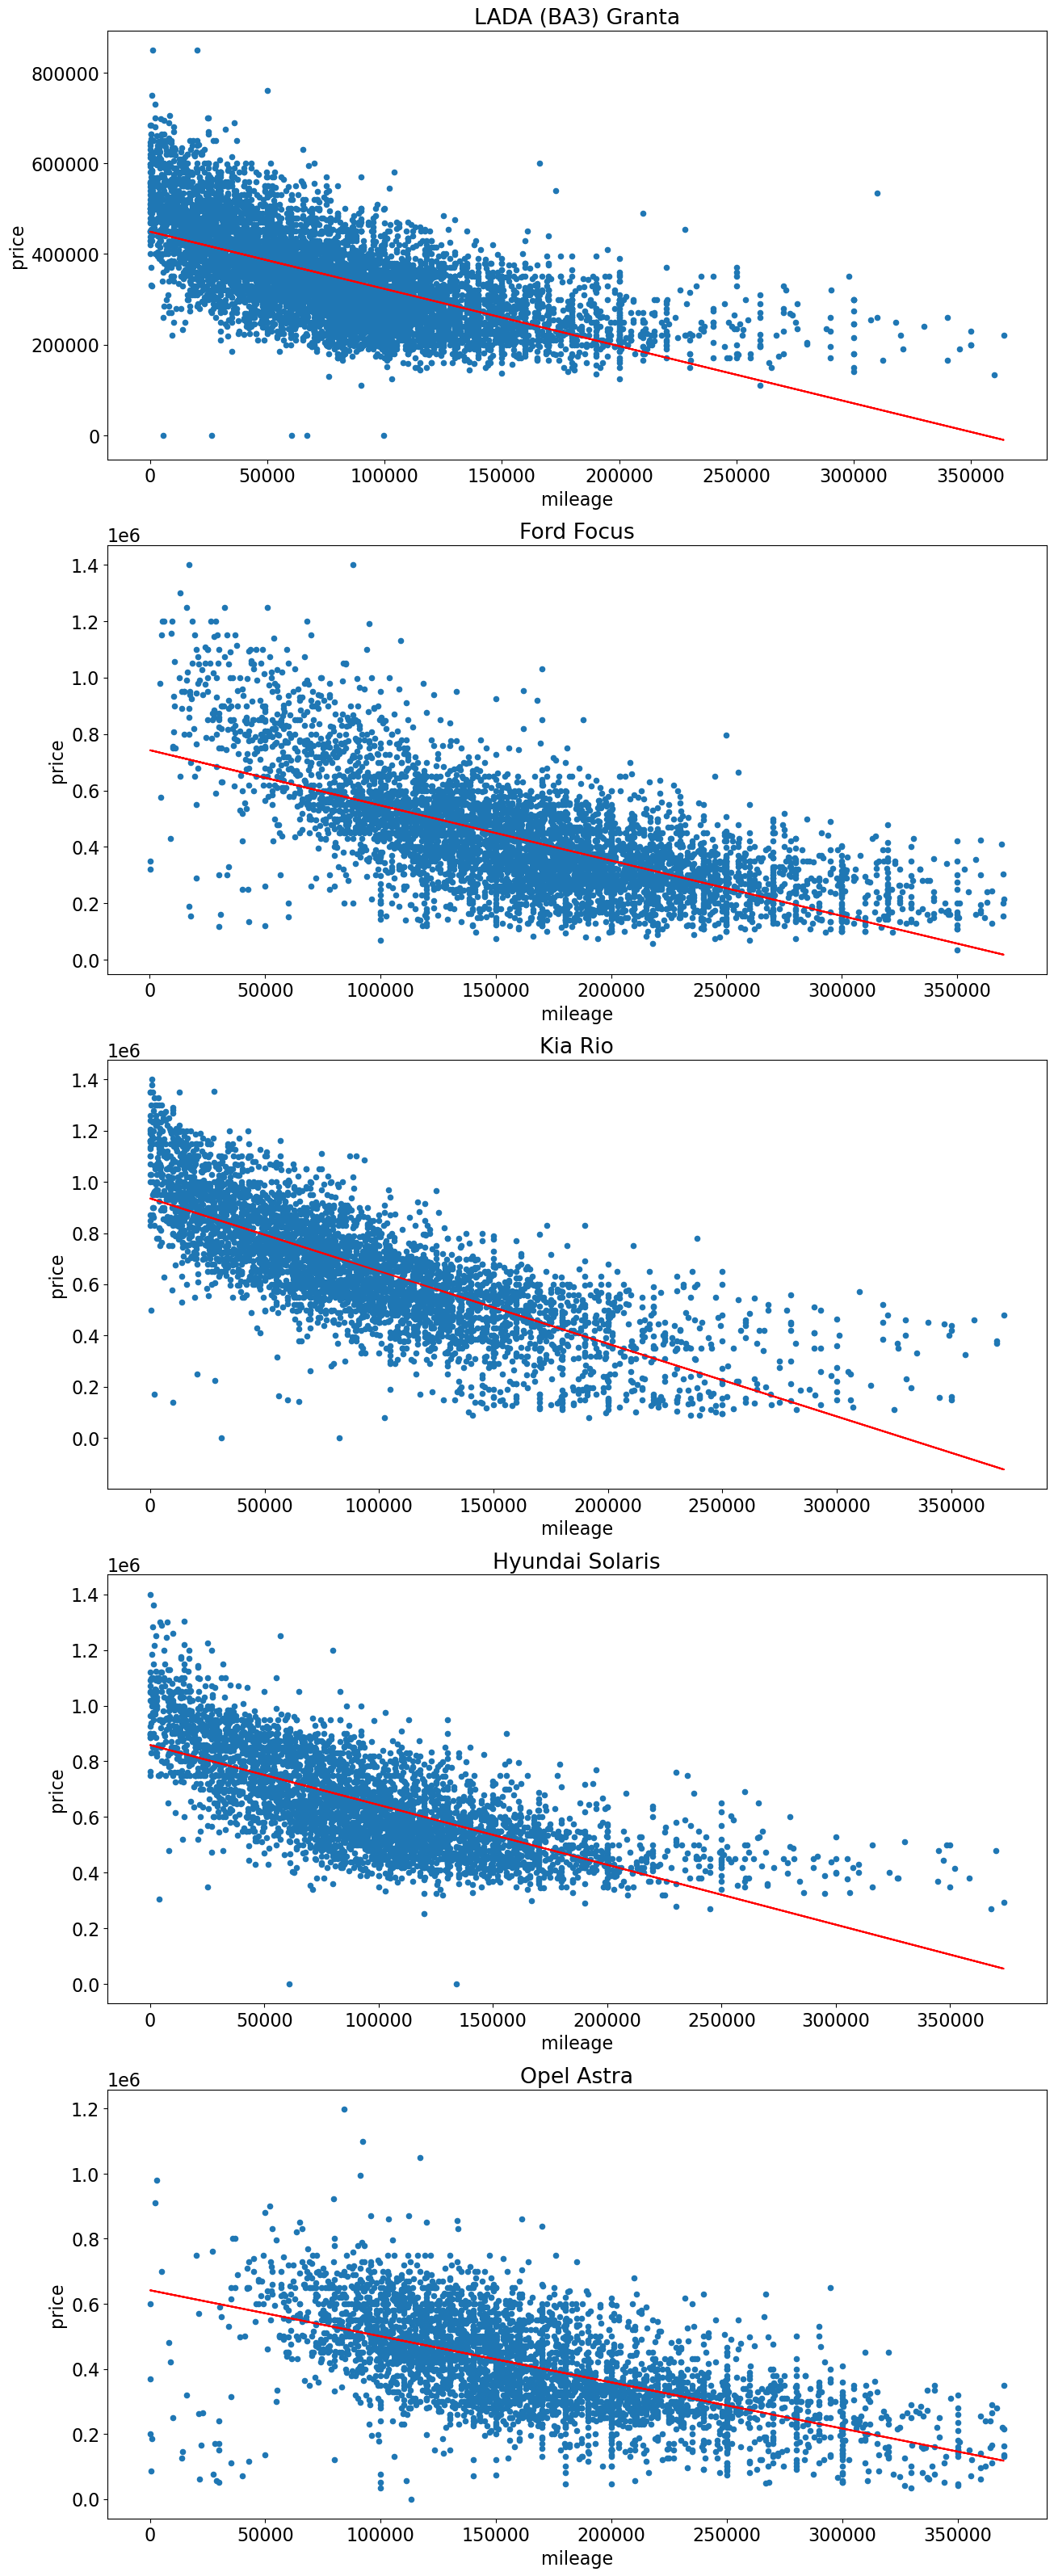

In [50]:
fig, axs = plt.subplots(nrows=5, figsize=(15,40))

for i in range(5):
    sub_df = df.select(df.price, df.mileage, ) \
                .filter((df.model == top_most_popular_models_df.iloc[i]['model'])) \
                .toPandas()
    q = sub_df.plot.scatter(x='mileage', y='price', ax=axs[i])
    a, b = np.polyfit(sub_df['mileage'], sub_df['price'], 1)
    w = axs[i].plot(sub_df['mileage'], a*sub_df['mileage']+b, color='Red')
    e = axs[i].set_title(top_most_popular_models_df.iloc[i]['brand'] + ' ' + top_most_popular_models_df.iloc[i]['model'])


Ценовую статистика для каждой марки автомобиля

In [51]:
brands_prices_statistic_df = []

for brand in all_brands:
    stat_dict = {'brand': brand}
    brand_prices_df = df.select(df.price).filter(df.brand==brand)
    stats = brand_prices_df.select(
        percentile_approx(df.price,[0.25,0.5,0.75,0.95], 1000000).alias("percentiles"),
        min('price').alias('min'),
        max('price').alias('max'),
        mean('price').alias('mean'),
        stddev('price').alias('stddev'),
    ).collect()[0]
    
    stat_dict['25th percentile'] = stats['percentiles'][0] 
    stat_dict['50th percentile'] = stats['percentiles'][1]
    stat_dict['75th percentile'] = stats['percentiles'][2]
    stat_dict['95th percentile'] = stats['percentiles'][3]
    
    stat_dict['min'] = stats['min']
    stat_dict['max'] = stats['max']
    stat_dict['mean'] = stats['mean']
    stat_dict['stddev'] = stats['stddev']
    
    brands_prices_statistic_df.append(stat_dict)
    
brands_prices_statistic_df = pd.DataFrame(brands_prices_statistic_df)
brands_prices_statistic_df

brand  25th percentile  50th percentile  75th percentile  \
0    Volkswagen           360000           580000           786999   
1         Simca            70000            70000            70000   
2    Oldsmobile           170000           260000           280000   
3      DW Hower          1000000          1050000          1100000   
4      Infiniti           985000          1230000          1350000   
..          ...              ...              ...              ...   
129    Mitsuoka           350000           600000           900000   
130         JMC           200000           200000           200000   
131         FSO            60000            60000            60000   
132       IVECO           360000           360000           360000   
133     Genesis          1449000          1449000          1449000   

     95th percentile      min      max          mean         stddev  
0            1199000       30  1465000  5.869152e+05  318632.479770  
1              70000    70000    70000  7.000000e+04            NaN  
2             400000    99000   400000  2.392222e+05  100325.442658  
3            1179000   950000  1190000  1.068193e+06   64133.309891  
4            1450000   105000  1460000  1.128088e+06  321870.758602  
..               ...      ...      ...           ...            ...  
129           900000   350000   900000  6.166667e+05  275378.527364  
130           200000   200000   200000  2.000000e+05            NaN  
131            60000    60000    60000  6.000000e+04            NaN  
132           360000   360000   360000  3.600000e+05            NaN  
133          1449000  1449000  1449000  1.449000e+06            NaN  

[134 rows x 9 columns]

Гистограммы (для статистики квантилей) и линейные диаграммы (для мин/макс/среднее/стандартное отклонение).

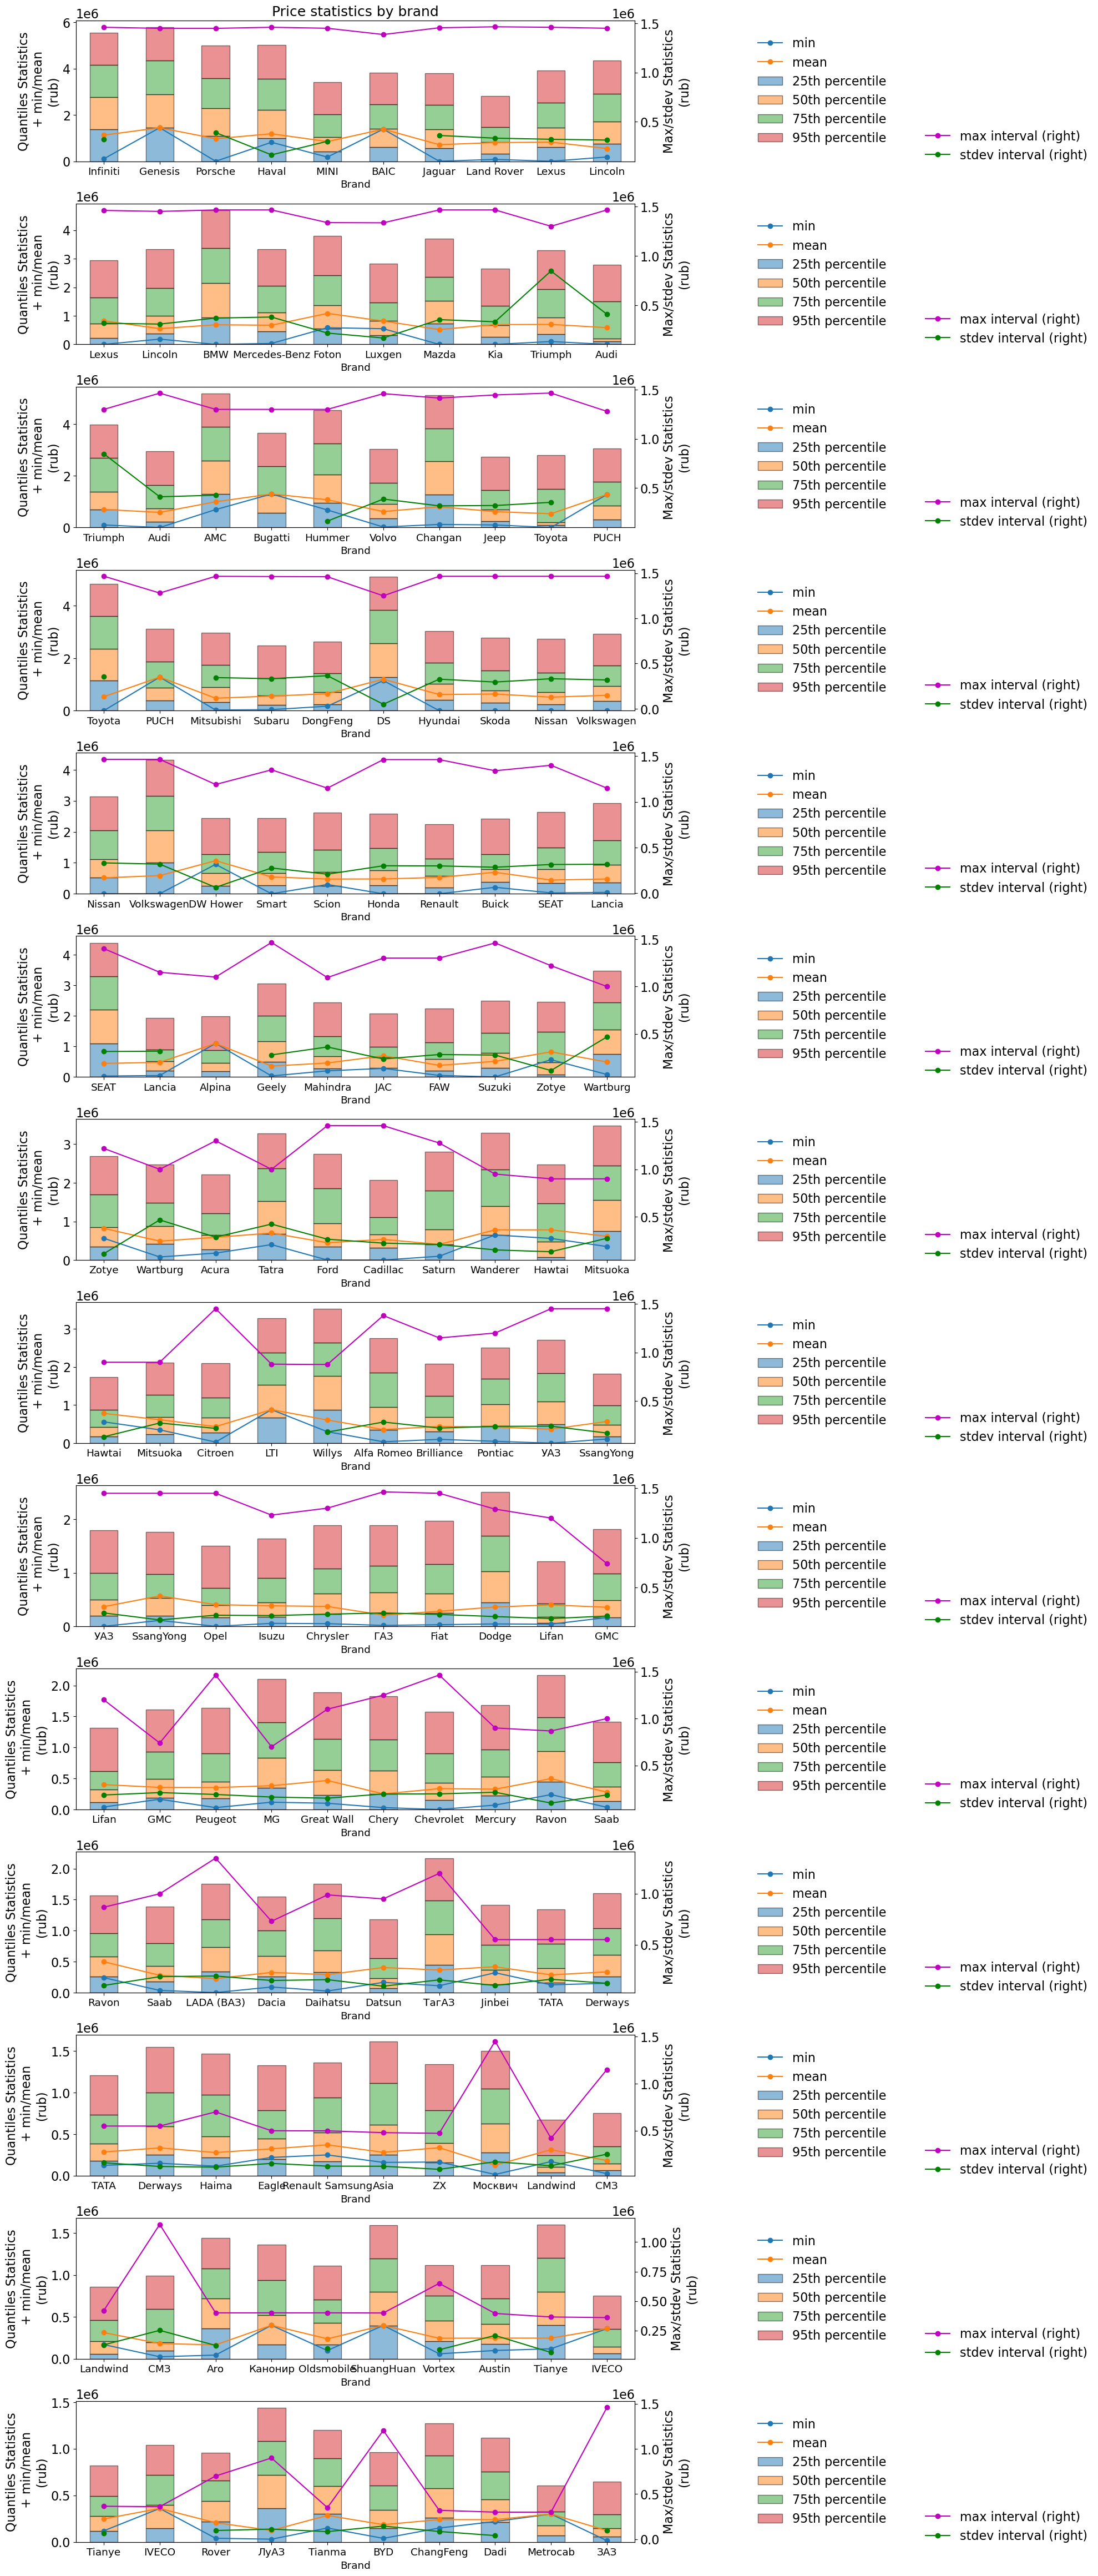

In [65]:
bar_columns = ['25th percentile', '50th percentile'
               , '75th percentile', '95th percentile']
line_columns1 = ['min', 'mean'] 
line_columns2 = ['max', 'stddev'] 
brands_prices_statistic_df = brands_prices_statistic_df.sort_values(
    by='95th percentile', ascending=False
)
figsize=(13, 59)
nrows = math.ceil(len(all_brands)/10)
fig, axs = plt.subplots(nrows=nrows, figsize=figsize)

d = axs[0].set_title('Price statistics by brand', fontsize=18)
for i in range (nrows):
    brands_prices_statistic_sub_df = brands_prices_statistic_df.iloc[i*8:i*8+10,]
    plot1 = brands_prices_statistic_sub_df[['brand'] + bar_columns] \
        .groupby(['brand']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i], 
    )
    plot2 = brands_prices_statistic_sub_df[['brand'] + line_columns1].plot(x='brand', ax=axs[i], marker='o')
    ax2 = axs[i].twinx()
    plot3 = brands_prices_statistic_sub_df[['brand'] + line_columns2].plot( x='brand', ax=ax2, marker='o', color=['m', 'g'])
    a = axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.5), frameon=False)
    a = ax2.legend(  labels=['max interval (right)', 'stdev interval (right)']
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.5, 0.11), frameon=False)
    b = axs[i].set_xticklabels(brands_prices_statistic_sub_df['brand'],rotation = 'horizontal', fontsize='small')
    c = axs[i].set_xlabel('Brand', fontsize='small');
    d = axs[i].set_ylabel('Quantiles Statistics\n + min/mean\n(rub)', fontsize=16);
    e = ax2.set_ylabel('Max/stdev Statistics\n(rub)', fontsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.3)
plt.show();

Вывод процентное использование автомобилей по виду топлива.

<AxesSubplot: ylabel='процент'>

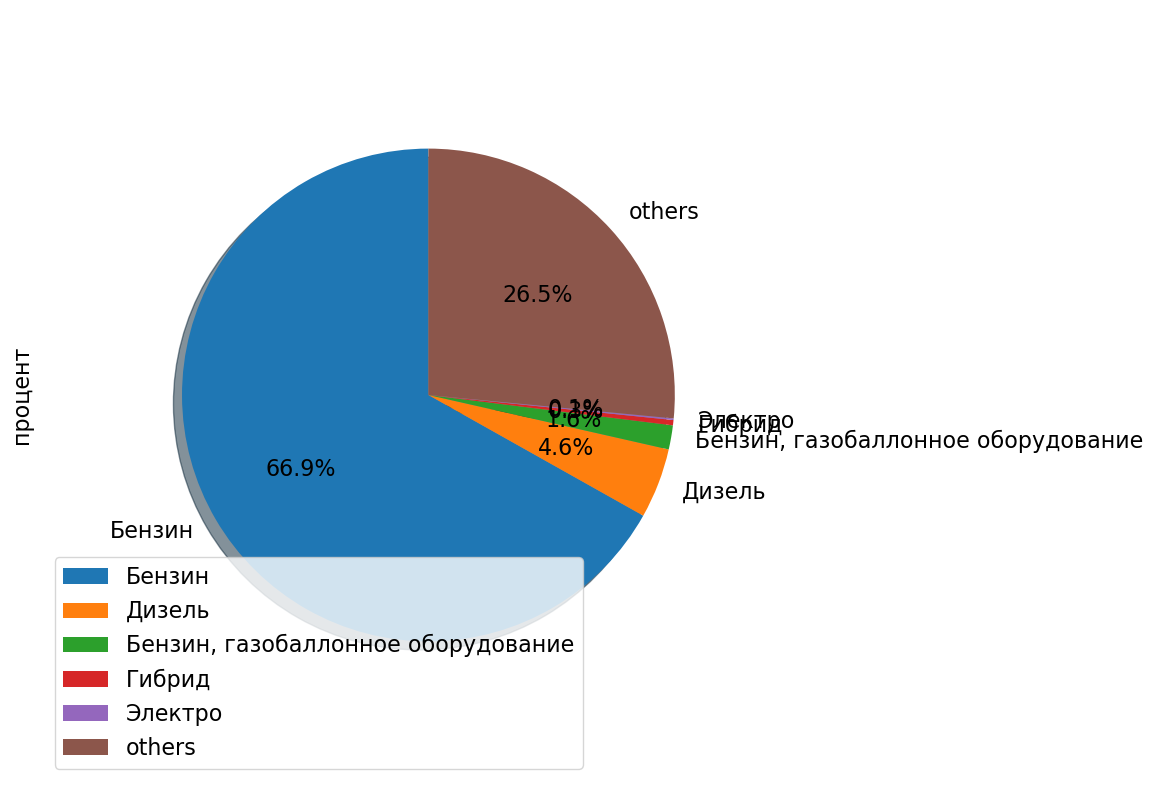

In [53]:
highest_fuel_types_df = df.select(df.fuel_type, df.offer_id) \
    .groupBy(df.fuel_type) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5) \
    .toPandas()

highest_fuel_types_df['процент'] = highest_fuel_types_df['count'] \
    / total_cars_count * 100

others = {
    'fuel_type': 'others', 
    'count': total_cars_count - np.sum(highest_fuel_types_df['count']), 
    'процент': 100 - np.sum(highest_fuel_types_df['процент'])
}

highest_fuel_types_df = pd.concat([highest_fuel_types_df,pd.DataFrame.from_dict([others])])

highest_fuel_types_df.plot.pie(
    y='процент',
    labels=highest_fuel_types_df['fuel_type'], 
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=90, 
    radius=0.8,
    figsize=(10, 10)
)

Топ продажи моделей у LADA (ВАЗ)

In [54]:
lada_cars_df = df.select(df.model, df.offer_id).filter(df.brand=='LADA (ВАЗ)') \
    .groupBy(df.model) \
    .count() \
    .orderBy('count', ascending=False)

lada_cars_df.toPandas()

model  count
0         Granta   8287
1         Priora   5633
2     2121 (4x4)   5089
3           2114   4530
4         Kalina   4323
5           2107   3963
6          Vesta   3912
7           2110   3848
8           2115   2793
9           2112   2598
10        Largus   2269
11          2109   2001
12         21099   1918
13          2106   1751
14          2105   1324
15          XRAY   1208
16    2131 (4x4)    986
17          2104    883
18          2111    834
19          2101    828
20      1111 Ока    729
21          2108    639
22          2113    631
23          2103    160
24          2102    103
25          2329     44
26  2120 Надежда     42
27          Niva     26
28          2129     11
29          2123     11
30       EL Lada      2

Также выведем ценовые характеристики для каждой найденной модели

In [55]:
Lada_models = df.select(df.model) \
    .filter((df.brand=='LADA (ВАЗ)')) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

df.select(df.model, df.price).filter(df.model.isin(Lada_models)) \
    .groupBy(df.model).agg(count("model").alias("count"), \
         avg("price").alias("avg_price"), \
         min("price").alias("min_price"), \
         max("price").alias("max_price") \
     ) \
    .orderBy('count', ascending=False) \
    .toPandas()

model  count       avg_price  min_price  max_price
0         Granta   8287   345225.398576         30     850000
1         Priora   5633   234785.365525      75000     750000
2     2121 (4x4)   5089   258950.670859          2    1200000
3           2114   4530   123141.493598         30     800000
4         Kalina   4323   222128.640065      42000    1000000
5           2107   3963    71438.948776      20000    1000000
6          Vesta   3912   640073.498978         30    1100000
7           2110   3848    87796.210759         30     400000
8           Niva   3413   356241.070026      60000     930000
9           2115   2793    97483.386323      25000     300000
10          2112   2598   103438.619323      25000     499000
11        Largus   2269   536685.121639     240000     981900
12          2109   2001    67232.613193      20000     999999
13         21099   1918    65794.263816      18000     315000
14          2106   1751    63551.483152       2115    1111111
15          2105   1324    65968.057402         50    1099000
16          XRAY   1208   623517.306291     399000    1250000
17    2131 (4x4)    986   255592.519270      50000     690000
18          2104    883    78606.479049      22000     400000
19          2111    834    97296.082734      20000     260000
20          2101    828   109394.724638      20000    1300000
21      1111 Ока    729    60164.207133      20000     350000
22          2108    639    70607.774648      20000    1350000
23          2113    631   117720.874802      30000     370000
24          2103    160   120889.356250      18000    1000000
25          2102    103   134710.359223      25000    1300000
26          2329     44   261879.545455      89000     597000
27  2120 Надежда     42   138703.690476      40000     270000
28          2129     11   120727.272727      55000     200000
29          2123     11   124545.454545      80000     180000
30       EL Lada      2  1000000.000000     900000    1100000

<AxesSubplot: xlabel='year'>

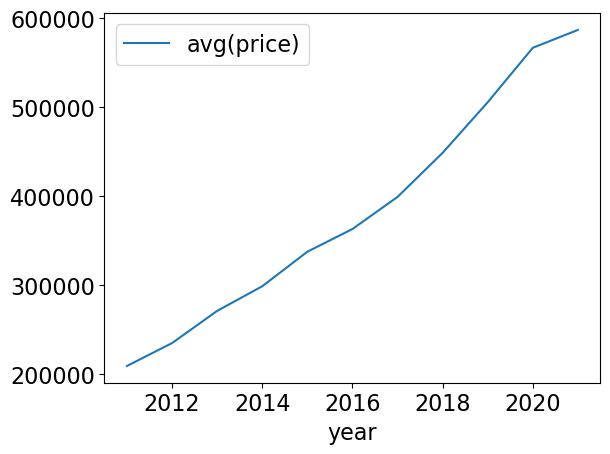

In [56]:
df.select( df.price, df.year) \
    .filter((df.model == 'Granta')) \
    .groupBy(df.year) \
    .avg('price') \
    .toPandas() \
    .sort_values(by='year', ascending=False) \
    .plot(x='year', y='avg(price)')